In [7]:
import urllib.parse
import numpy as np
import pandas as pd
import random as rd
from scipy.stats import bernoulli

domain = "51.91.251.0"
port = 3000
host = f"http://{domain}:{port}"
path = lambda x: urllib.parse.urljoin(host, x)

In [3]:
import requests

user_id = '70868297-ced7-46d3-8a7a-4ca528e49009'
name = 'hugo-first-avatar'
r = requests.post(path(f'avatars/{user_id}/{name}'))
r

<Response [409]>

In [4]:
pricing_requests = pd.read_csv("pricing_requests.csv")
test_sample = pd.read_csv("test_set.csv")

In [4]:
list_cities = ["amsterdam", "copenhagen", "madrid", "paris", "rome", "sofia", "valletta", "vienna", "vilnius"]
list_date = [k for k in range(45)]
list_languages = ["austrian", "belgian", "bulgarian", "croatian", "cypriot", "czech", "danish", "dutch",
                  "estonian", "finnish", "french", "german", "greek", "hungarian", "irish", "italian",
                  "latvian", "lithuanian", "luxembourgish", "maltese", "polish", "portuguese", "romanian",
                  "slovakian", "slovene", "spanish", "swedish"]

In [59]:
def GetDatesTest(test_sample):
    list_dates_test = []
    for avatar_id in test_sample.avatar_id.unique():
        dates = [ind for ind in test_sample.loc[test_sample.avatar_id == avatar_id, "date"].unique()]
        list_dates_test.append(dates)
    return(list_dates_test)

def GetCitiesLanguagesTest(test_sample):
    list_cities_languages_test = []
    for rq_nb in test_sample.order_requests.unique():
        temp = test_sample.loc[test_sample.order_requests == rq_nb, ["city","language"]].drop_duplicates()
        list_cities_languages_test.append([temp.city.values[0], temp.language.values[0]])
    return(list_cities_languages_test)

def CreateWiseRequestParams(nb_avatars, list_dates, list_cities_languages, p_mobile):
    list_params = []
    for i in range(nb_avatars):
        num_avatar = rd.randint(0, 100000)
        name = "AvatarNumero"+str(num_avatar)
        dates_avatar = rd.choice(list_dates)
        city_language = rd.choice(list_cities_languages)
        mobile = np.random.binomial(1,p_mobile)
        language = city_language[1]
        city = city_language[0]
        r = requests.post(path(f"avatars/{user_id}/{name}"))
        for date in np.sort(dates_avatar)[::-1]:
            params = {"avatar_name": name,
                       "language": language,
                       "city": city,
                       "date": date,
                       "mobile": mobile,
                    }
            list_params.append(params)
    return(list_params)

list_dates_test = GetDatesTest(test_sample)
list_cities_languages_test = GetCitiesLanguagesTest(test_sample)
temp_mobile = test_sample.loc[:,["mobile","order_requests"]].drop_duplicates()
p_mobile_test = len(temp_mobile[temp_mobile.mobile == 1])/len(temp_mobile)


In [15]:
def CreateRequestParams(nb_avatars, nb_requests):
    list_params = []
    for i in range(nb_avatars):
        num_avatar = rd.randint(0, 100000)
        name = "AvatarNumero"+str(num_avatar)
        if nb_requests > 1 :
            date = np.random.randint(12,44)
        else: date = rd.choice(list_date)
        r = requests.post(path(f"avatars/{user_id}/{name}"))
        for j in range(nb_requests):
            change = np.random.binomial(1,0.7)
            if change or j == 0:
                language = rd.choice(list_languages)
                city = rd.choice(list_cities)
                mobile = rd.randint(0,1)
            params = {"avatar_name": name,
                       "language": language,
                       "city": city,
                       "date": date,
                       "mobile": mobile,
                    }
            date = date - np.random.randint(1,4)
            if params not in list_params:
                list_params.append(params)
    return(list_params)

In [50]:
def AddRequestOrder(df, request_order = 1):
    data = df.copy()
    data["request_order"] = np.nan
    data["avatar_nb_requests"] = np.nan
    avatar_id = data.loc[0,"avatar_id"]
    date = data.loc[0,"date"]
    city = data.loc[0,"city"]
    language = data.loc[0,"language"]
    mobile = data.loc[0,"mobile"]
    avatar_nb_requests = 1
    for k in range(len(data)):
        if data.loc[k,"avatar_id"] != avatar_id :
            avatar_id = data.loc[k,"avatar_id"]
            date = data.loc[k,"date"]
            city = data.loc[k,"city"]
            language = data.loc[k,"language"]
            mobile = data.loc[k,"mobile"]
            avatar_nb_requests = 1
            request_order += 1
        elif data.loc[k,"date"] != date or data.loc[k,"city"] != city or data.loc[k,"language"] != language or data.loc[k,"mobile"] != mobile:
            date = data.loc[k,"date"]
            city = data.loc[k,"city"]
            language = data.loc[k,"language"]
            mobile = data.loc[k,"mobile"]
            avatar_nb_requests += 1
            request_order += 1
        data.loc[k,"request_order"] = request_order
        data.loc[k,"avatar_nb_requests"] = avatar_nb_requests
    return data
        

In [134]:
def MakeRequests(list_params):
    pricing_requests = []
    for params in list_params:
        try:
            req = requests.get(path(f"pricing/{user_id}"), params=params)
            pricing_requests.append(
            pd.DataFrame(req.json()['prices']).assign(**req.json()['request']))
        except KeyError:
            print("vla ti pas une erreur bondiou")
    pricing_requests = pd.concat(pricing_requests, ignore_index = True)
    return(pricing_requests)

def MergeRequestsResults(Big_df, New_df):
    big_df = Big_df.copy()
    request_order = big_df.request_order[len(big_df)-1] + 1
    new_df = AddRequestOrder(New_df, request_order = request_order)
    res = pd.concat([big_df, new_df], ignore_index = True)
    return(res)

In [ ]:
list_params = CreateWiseRequestParams(100, list_dates_test, list_cities_languages_test, p_mobile_test)
New_df = MakeRequests(list_params)
new_pricing_requests = MergeRequestsResults(new_pricing_requests, New_df)

In [149]:
new_pricing_requests.to_csv('new_pricing_requests.csv', index=False)

In [21]:
pricing_requests.to_csv('pricing_requests.csv', index=False)

In [20]:
pricing_requests

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_order,avatar_nb_requests
0,300,145,1,copenhagen,2,hungarian,0,28434,1.0,1.0
1,855,311,1,copenhagen,2,hungarian,0,28434,1.0,1.0
2,757,151,1,copenhagen,2,hungarian,0,28434,1.0,1.0
3,805,202,2,copenhagen,2,hungarian,0,28434,1.0,1.0
4,930,120,0,copenhagen,2,hungarian,0,28434,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
450337,617,310,50,paris,20,danish,0,243251,4197.0,4.0
450338,27,267,69,paris,20,danish,0,243251,4197.0,4.0
450339,937,221,26,paris,20,danish,0,243251,4197.0,4.0
450340,756,220,34,paris,20,danish,0,243251,4197.0,4.0


In [45]:
def CreateRequestParams2(date):
    list_params = []
    mobile = 0
    for city in list_cities:
        num_avatar = rd.randint(0, 100000)
        name = "AvatarNumero"+str(num_avatar)
        r = requests.post(path(f"avatars/{user_id}/{name}"))
        language = rd.choice(list_languages)
        params = {"avatar_name": name,
                       "language": language,
                       "city": city,
                       "date": date,
                       "mobile": mobile,
                    }
        list_params.append(params)
    return(list_params)

In [62]:
data_requests = pd.read_csv("data_requests.csv")

In [73]:
list_params = CreateRequestParams2(0)
New_df = MakeRequests(list_params)
data_requests = MergeRequestsResults(data_requests, New_df)

In [76]:
data_requests.to_csv("data_requests.csv", index=False)

In [7]:
import matplotlib.pyplot as plt
# plt.hist(data_requests.city)
# pricing_requests[pricing_requests.request_number==1].groupby('hotel_id').count().describe()

In [56]:
data_requests[data_requests.hotel_id == 995]

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_id,request_number
229,995,186,197,copenhagen,44,croatian,0,129300,copenhagencroatian129300,1.0
4006,995,192,72,copenhagen,30,german,0,129344,copenhagengerman129344,1.0


In [81]:
full_data = res = pd.concat([pricing_requests, data_requests], ignore_index = True)

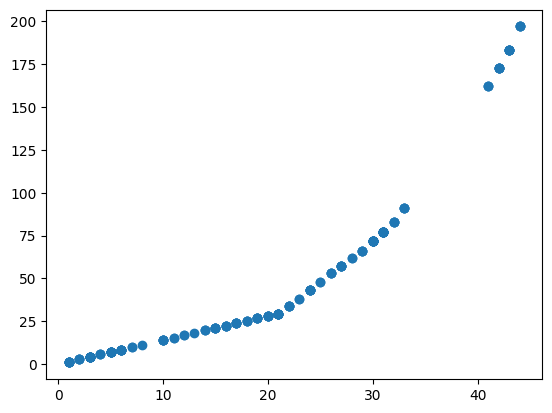

In [144]:
hotel_15 = pricing_requests[(pricing_requests.hotel_id == 995)&(pricing_requests.stock > 0)]
plt.scatter(hotel_15.date,hotel_15.stock)

In [8]:
data_avatars = pd.DataFrame()

In [ ]:
for language in list_languages:
    num_avatar = rd.randint(0,100000)
    name = "AvatarNumero"+str(num_avatar)
    date = 30
    r = requests.post(path(f"avatars/{user_id}/{name}"))
    city = "vienna"
    mobile = 0
    params = {"avatar_name": name,
                "language": language,
                "city": city,
                "date": date,
                "mobile": mobile,
            }
data_requests = MakeRequests([params])

data_avatars = res = pd.concat([data_avatars, data_requests], ignore_index = True)

In [56]:
data_avatars

,hotel_id,price,stock,city,date,language,mobile,avatar_id
1581,944,235,147,rome,35,french,0,172260
1621,944,245,120,rome,32,french,0,172260
1784,944,231,147,rome,35,italian,0,172261
1862,944,240,120,rome,32,italian,0,172261
2007,944,235,147,rome,35,lithuanian,0,172262
2210,944,245,120,rome,32,lithuanian,0,172262


In [ ]:
for hotel_id in data_avatars.hotel_id:
    plt.scatter(data_avatars.loc[data_avatars.hotel_id==hotel_id].hotel_id,data_avatars.loc[data_avatars.hotel_id==hotel_id].price)

In [224]:
pricing_requests

,hotel_id,price,stock,city,date,language,mobile,avatar_id,request_order,avatar_nb_requests
0,300,145,1,copenhagen,2,hungarian,0,28434,1.0,1.0
1,855,311,1,copenhagen,2,hungarian,0,28434,1.0,1.0
2,757,151,1,copenhagen,2,hungarian,0,28434,1.0,1.0
3,805,202,2,copenhagen,2,hungarian,0,28434,1.0,1.0
4,930,120,0,copenhagen,2,hungarian,0,28434,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
325203,301,109,46,paris,32,belgian,1,189755,3037.0,3.0
325204,254,157,68,paris,32,belgian,1,189755,3037.0,3.0
325205,797,114,58,paris,32,belgian,1,189755,3037.0,3.0
325206,49,157,78,paris,32,belgian,1,189755,3037.0,3.0


In [273]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

df = pricing_requests.loc[:, ['price','language','city','hotel_id','date','avatar_nb_requests']]

list_hotel = df.hotel_id.unique()
list_hotel_price = []
for hotel_id in list_hotel:
    sub_df = df[df.hotel_id == hotel_id]
    list_hotel_price.append(np.mean(sub_df.price))

df.hotel_id = pd.Categorical(df.hotel_id)
mean_prices = pd.DataFrame({"price_hotel":list_hotel_price,"hotel_id":list_hotel})
merged_df = df.merge(mean_prices, on = "hotel_id")

# merged_df = SameCountry(merged_df)

merged_df = merged_df[['price','date','price_hotel','language','city','avatar_nb_requests']]
bdd_dummies = pd.get_dummies(data=merged_df, columns = ['language','city'], drop_first=True)
# bdd_dummies = pd.get_dummies(data=bdd, columns = ['brand','city'], drop_first=True)
data_train = bdd_dummies
# data_train,data_test = train_test_split(bdd_dummies,test_size=0.25,random_state=1)
X_train = data_train.loc[:,data_train.columns != "price"].copy()
Y_train = data_train.loc[:,"price"].copy()
# X_test = data_test.loc[:,data_train.columns != "price"].copy()
# Y_test = data_test.loc[:,"price"].copy()

In [274]:
from sklearn.metrics import mean_squared_error
rf = RandomForestRegressor().fit(X_train, Y_train)
# y_pred_rf = rf.predict(X_test)
# MSE_rf = mean_squared_error(Y_test,y_pred_rf)
# print(MSE_rf)

In [275]:
df_test = pd.read_csv("test_set.csv")
df_test["index_test"] = df_test.index
df_test = AddRequestOrder(df_test).drop("request_order",axis=1)
df_test = df_test.merge(mean_prices, on = "hotel_id")
df_test_pred = pd.get_dummies(data=df_test.sort_values("index_test").drop(["order_requests","hotel_id","index_test","mobile","avatar_id","stock","index"],axis=1), columns = ["language","city"], drop_first=True).reset_index(drop=True)
y_pred_rf = rf.predict(df_test_pred[X_train.columns])
submission = pd.DataFrame({"index" : df_test.index, "price" : y_pred_rf})
submission.to_csv('submission.csv', index=False)

In [276]:
pd.DataFrame({"variable":X_train.columns, "importance":rf.feature_importances_}).sort_values("importance", ascending=False)

,variable,importance
1,price_hotel,0.886753
0,date,0.095567
31,city_paris,0.003443
29,city_copenhagen,0.003069
30,city_madrid,0.002201
35,city_vienna,0.001328
32,city_rome,0.001182
36,city_vilnius,0.001036
2,avatar_nb_requests,0.000704
33,city_sofia,0.000554


In [60]:
def TestSameCountry(city, language):
    if city == "amsterdam" and language == "dutch":
        return True
    if city == "copenhagen" and language == "danish":
        return True
    if city == "madrid" and language == "spanish":
        return True
    if city == "paris" and language == "french":
        return True
    if city == "rome" and language == "italian":
        return True
    if city == "sofia" and language == "bulgarian":
        return True
    if city == "valleta" and language == "maltese":
        return True
    if city == "vienna" and language == 'austrian':
        return True
    if city == "vilnius" and language == "lithuanian":
        return True
    else:
        return False

def SameCountry(db):
    data = db.copy()
    data["same_country"] = 0
    for k in range(len(data)):
        if TestSameCountry(data.loc[k,"city"], data.loc[k,"language"]):
            data.loc[k,"same_country"] = 1
    return data

In [277]:
submission.describe()

,index,price
count,6644.000000,6644.000000
mean,3321.500000,177.804518
std,1918.101926,100.638566
min,0.000000,41.290000
25%,1660.750000,98.518080
50%,3321.500000,148.793833
75%,4982.250000,227.561250
max,6643.000000,452.065063
